# Test Shubert 2D
---
Description:

- Optimization (min)
- Multimodal (yes)
---
The Shubert function has several local minima and many global minima. The equation is given by:

$f\left(x, y\right) = \left(\sum_{i=1}^5 i* \cos((i+1)*x + i)\right) \left(\sum_{i=1}^5 i* \cos((i+1)*y + i)\right)$

The function is usually evaluated on the square $x, y \in [-10, 10]$, although this may be restricted
to the square $x, y \in [-5.12, 5.12]$.

Global minimum:
$f^*(x_{opt}, y_{opt}) = -186.7309$

## First we import python libraries and set up the directory

In [10]:
import os, sys
import json

import numpy as np
from numba import njit
from scipy.stats import qmc
from collections import defaultdict
from matplotlib import pyplot as plt

# Enable LaTex in plotting.
plt.rcParams["text.usetex"] = True

PROJECT_DIR = os.path.abspath("..")
sys.path.append(PROJECT_DIR)

## Here we import all our custom PSO code

In [11]:
from star_pso.auxiliary.swarm import Swarm
from star_pso.auxiliary.particle import Particle
from star_pso.engines.standard_pso import StandardPSO
from star_pso.auxiliary.utilities import cost_function

In [12]:
def count_particles_per_mode(x_pos: np.ndarray, modes: list,
                             radius: int = 1.0) -> dict:
    cppm = defaultdict(int)

    for px, py in x_pos:
        for vals in modes:
            cx, cy = vals
            if (px - cx)**2 + (py - cy)**2 <= radius**2:            
                cppm[tuple(vals)] += 1
                break
            # _end_if_
    # _end_for_
    return cppm
# _end_def_

## Define the multi-modal function

$f\left(x, y\right) = \left(\sum_{i=1}^5 i* \cos((i+1)*x + i)\right) \left(\sum_{i=1}^5 i* \cos((i+1)*y + i)\right)$

In [13]:
@njit(fastmath=True)
def fun_shubert_vectorized(x: np.ndarray, y: np.ndarray) -> np.ndarray:
    # Define the range [1, 2, 3, 4, 5].
    i = np.arange(1, 6)

    # Calculate the first summation over each x.
    sum_x = np.sum(i[:, np.newaxis] * np.cos((i[:, np.newaxis] + 1) * x + i[:, np.newaxis]), axis=0)

    # Calculate the second summation over each y.
    sum_y = np.sum(i[:, np.newaxis] * np.cos((i[:, np.newaxis] + 1) * y + i[:, np.newaxis]), axis=0)

    # Return the product of both sums.
    return sum_x * sum_y

In [14]:
@cost_function(minimize=True)
def fun_test2D(x_array: np.ndarray, **kwargs) -> float:

    # Extract the values.
    x, y = x_array
    
    # Compute the final value.
    f_xy = fun_shubert_vectorized(x, y)
    
    # Return the solution.
    return f_xy.item()
# _end_def_

In [15]:
# Prepare a list with all the global optima.
global_optima =[(-7.0835, -7.7083),
                (-7.0835, -1.4250),
                (-7.0835, +4.8601),
                
                (-0.8003, -7.7083),
                (-0.8003, -1.4250),
                (-0.8003, +4.8601),
                
                (+5.4858, -7.7083),
                (+5.4858, -1.4250),
                (+5.4858, +4.8601),
                
                (-7.7083, -7.0835),
                (-7.7083, -0.8003),
                (-7.7083, +5.4858),
                
                (-1.4250, -7.0835),
                (-1.4250, -0.8003),
                (-1.4250, +5.4858),
                
                (+4.8601, -7.0835),
                (+4.8601, -0.8003),
                (+4.8601, +5.4858)]

optima = np.array(global_optima)

## TBD
...

In [16]:
# Random number generator.
rng = np.random.default_rng()

# Set the upper/lower bounds.
l_bounds = [-10.0, -10.0]
u_bounds = [+10.0, +10.0]

# Define the initialization sampling method.
sample_method = "LATINHC"

# Define the dimensions of the problem (positions vector).
n_dim = 2

# Draw samples using Latin Hyper Cube approach.
lhc_sampler = qmc.LatinHypercube(n_dim, rng=rng, optimization="random-cd")

# List all the possible swarm sizes.
swarm_size = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]

# define the number of repeatitions.
n_repeats = 40

# Stores the statistics.
stats_per_run = defaultdict(list)

# Setup the main loop.
for n_size in swarm_size:

    print(f"Running simulation with swarm size={n_size} ... \n")

    for k in range(n_repeats):

        print(f"Repeatition {k} in process ... ")

        if sample_method == "RANDOM":
            # Draw random samples for the initial points.
            Xt0 = rng.uniform(-10.0, +10.0, size=(n_size, n_dim))
        else:
            # Sample initial positions.
            Xt0 = lhc_sampler.random(n_size)
        
            # Scale the positions.
            Xt0 = qmc.scale(Xt0, l_bounds, u_bounds)
        # _end_if_
    
        # Initial population.
        swarm_t0 = Swarm([Particle(x) for x in Xt0])
    
        # Create the StandardPSO object that will carry on the optimization.
        test_PSO = StandardPSO(initial_swarm = swarm_t0, obj_func = fun_test2D,
                               x_min = l_bounds, x_max = u_bounds)
        # Run the experiment.
        test_PSO.run(max_it = 500,
                     options = {"w0": 0.75, "c1": 1.50, "c2": 1.50, "mode": "multimodal"},
                     reset_swarm = False, verbose = False, adapt_params = False)
        
        # Leave a blank line between repeatitions.
        print(" ")
    
        # Extract all the particles.
        best_n = test_PSO.swarm.positions_as_array()
    
        # Count the number of global optima.
        counts = count_particles_per_mode(best_n, global_optima, radius=0.15)
    
        # Update the dictionary.
        stats_per_run[n_size].append(len(counts))
    # _end_for__
# _end_for_

# Save the results.
with open(f"result_{sample_method}_01.json", 'w') as fp:
    json.dump(stats_per_run, fp)

# Display final message.
print(f"Experiment {sample_method} FINISHED.")

Running simulation with swarm size=50 ... 

Repeatition 0 in process ... 
Initial f_optimal = 90.3319
Final f_optimal = 186.7309
run: elapsed time = 2.827 seconds.
 
Repeatition 1 in process ... 
Initial f_optimal = 39.5645
Final f_optimal = 186.7309
run: elapsed time = 0.941 seconds.
 
Repeatition 2 in process ... 
Initial f_optimal = 120.0803
Final f_optimal = 186.7309
run: elapsed time = 0.934 seconds.
 
Repeatition 3 in process ... 
Initial f_optimal = 63.2217
Final f_optimal = 186.7309
run: elapsed time = 0.958 seconds.
 
Repeatition 4 in process ... 
Initial f_optimal = 123.6379
Final f_optimal = 186.7309
run: elapsed time = 0.963 seconds.
 
Repeatition 5 in process ... 
Initial f_optimal = 119.5549
Final f_optimal = 186.7309
run: elapsed time = 1.052 seconds.
 
Repeatition 6 in process ... 
Initial f_optimal = 39.4346
Final f_optimal = 186.7309
run: elapsed time = 1.031 seconds.
 
Repeatition 7 in process ... 
Initial f_optimal = 41.2019
Final f_optimal = 186.7309
run: elapsed t

### Plot the results

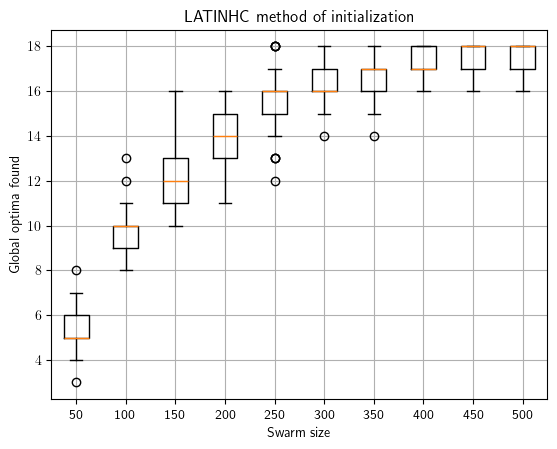

In [17]:
# Get the data (counts).
labels, data = stats_per_run.keys(), stats_per_run.values()

plt.boxplot(data)
plt.xticks(range(1, len(labels) + 1), labels)

plt.title(f"{sample_method} method of initialization")
plt.xlabel("Swarm size")
plt.ylabel("Global optima found")
plt.grid()

# Save to file.
plt.savefig(f"{sample_method}_method.pdf", format="pdf", dpi=300)

### End of file